In [1]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../..')
from viz.goals_origin import plot_goals_origin
from viz.assisted_goals import plot_assisted_goals
from viz.assist_passes import plot_assist_passes
from viz.dribbles_heatmap import plot_dribbles_heatmap

BACKGROUND_COLOR = '#313332'
font = 'DejaVu Sans'
SUCCESS_COLOR = '#00FF7F'
FAIL_COLOR = '#FF6B6B'

ORIGIN_COLORS = {
    'Asistido': '#00FF7F',
    'Regate previo': '#00D9FF',
    'Carry individual': '#FFD700',
    'Rebote': '#CCCCCC'
}

In [2]:
DATA_DIR = './data'

match_folders = sorted([f for f in os.listdir(DATA_DIR) 
                       if os.path.isdir(os.path.join(DATA_DIR, f))])

print(f"Partidos encontrados: {len(match_folders)}")

Partidos encontrados: 38


In [3]:
def load_all_events():
    all_events = []
    
    for folder in match_folders:
        folder_path = os.path.join(DATA_DIR, folder)
        match_date = folder.split('_')[0]
        
        try:
            df = pd.read_csv(os.path.join(folder_path, 'match_events.csv'))
            df['match_folder'] = folder
            df['match_date'] = match_date
            all_events.append(df)
        except Exception as e:
            print(f"Error en {folder}: {e}")
    
    return pd.concat(all_events, ignore_index=True)

print("Cargando eventos...")
df_events = load_all_events()
df_messi = df_events[df_events['player'] == 'Lionel Messi'].copy()

print(f"Total eventos: {len(df_events):,}")
print(f"Eventos de Messi: {len(df_messi):,}")

Cargando eventos...
Total eventos: 72,761
Eventos de Messi: 2,814


In [4]:
def get_previous_events(df, event_idx, window=5):
    event = df.iloc[event_idx]
    team = event['team']
    possession_id = event.get('possession_id')
    
    prev = df[
        (df.index < event_idx) &
        (df['team'] == team) &
        (df['possession_id'] == possession_id)
    ].tail(window)
    
    return prev

In [5]:
real_assists = df_messi[
    (df_messi['event_type'] == 'Pass') &
    (df_messi['pass_outcome'] == 'Goal')
].copy()

print(f"Asistencias REALES: {len(real_assists)}")

Asistencias REALES: 57


In [6]:
def classify_goal_origin(goal_event, df_events):
    prev = get_previous_events(df_events, goal_event.name, window=5)
    
    if len(prev) > 0:
        messi_events = prev[prev['player'] == goal_event['player']]
        
        if len(messi_events) > 0:
            if any(messi_events['event_type'] == 'TakeOn'):
                takeons = messi_events[messi_events['event_type'] == 'TakeOn']
                if any(takeons['outcome_type'] == 'Successful'):
                    return 'Regate previo'
            
            if any(messi_events['event_type'] == 'Carry'):
                carries = messi_events[messi_events['event_type'] == 'Carry']
                long_carries = carries[carries['pass_distance'] > 15]
                if len(long_carries) > 0:
                    return 'Carry individual'
        
        if any(prev['event_type'] == 'Pass'):
            last_pass = prev[prev['event_type'] == 'Pass'].iloc[-1]
            if last_pass['player'] != goal_event['player']:
                return 'Asistido'
    
    return 'Rebote'

goals_messi = df_messi[
    (df_messi.get('is_goal', False)) | 
    (df_messi['event_type'].str.contains('Goal', case=False, na=False))
].copy()

goals_messi['origin_type'] = goals_messi.apply(
    lambda row: classify_goal_origin(row, df_events), axis=1
)

print(f"Goles de Messi: {len(goals_messi)}")
print(goals_messi['origin_type'].value_counts())

Goles de Messi: 32
origin_type
Asistido            26
Regate previo        3
Rebote               2
Carry individual     1
Name: count, dtype: int64


In [7]:
dribbles_messi = df_messi[df_messi['event_type'] == 'TakeOn'].copy()
print(f"Regates: {len(dribbles_messi)}")
print(f"Exitosos: {(dribbles_messi['outcome_type'] == 'Successful').sum()}")

Regates: 209
Exitosos: 97


In [8]:
def get_assisted_goals(df_messi, df_events):
    assists = df_messi[
        (df_messi['event_type'] == 'Pass') &
        (df_messi['pass_outcome'] == 'Goal')
    ].copy()

    assisted_goals = []
    for idx in assists.index:
        assist = assists.loc[idx]
        team = assist['team']
        possession_id = assist.get('possession_id')

        next_events = df_events[
            (df_events.index > idx) &
            (df_events['team'] == team) &
            (df_events['possession_id'] == possession_id)
        ].head(3)

        for _, event in next_events.iterrows():
            if event.get('is_shot', False) or event.get('is_goal', False):
                shot_data = {
                    'x_assist': assist['x'],
                    'y_assist': assist['y'],
                    'x_shot': event['x'],
                    'y_shot': event['y'],
                    'xg': event.get('xg', 0.1),
                    'is_goal': event.get('is_goal', False),
                    'body_part': event.get('shot_body_part', 'Foot'),
                    'shooter': event.get('player', 'Unknown')
                }
                assisted_goals.append(shot_data)
                break

    return pd.DataFrame(assisted_goals)

assisted_goals = get_assisted_goals(df_messi, df_events)
assisted_goals.to_csv('./outputs/messi_assisted_goals.csv', index=False)
print(f"Goles asistidos: {len(assisted_goals)}")

Goles asistidos: 57


In [9]:
real_assists.to_csv('./outputs/messi_assists.csv', index=False)
goals_messi.to_csv('./outputs/messi_goals.csv', index=False)
dribbles_messi.to_csv('./outputs/messi_dribbles.csv', index=False)

print("CSVs guardados")

CSVs guardados


Viz 1: Goals by Origin - Guardado


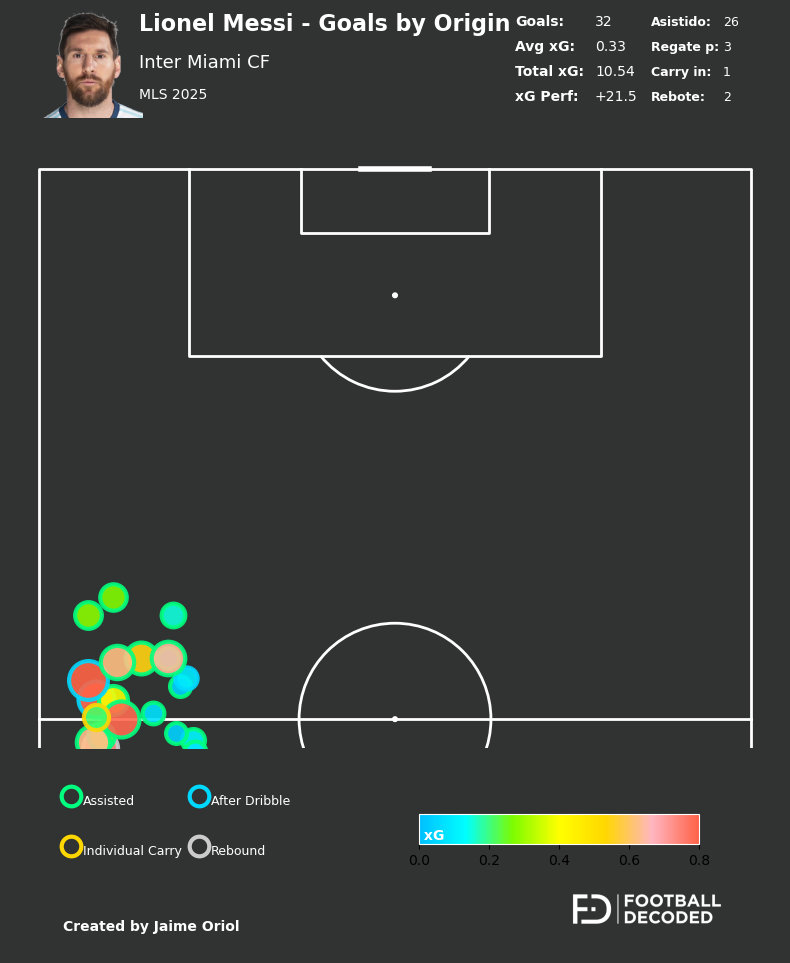

In [10]:
# Viz 1: Goals by Origin
fig1 = plot_goals_origin(
    csv_path='./outputs/messi_goals.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/01_goals_origin.png'
)
print("Viz 1: Goals by Origin - Guardado")

KeyError: "[' x_assist'] not in index"

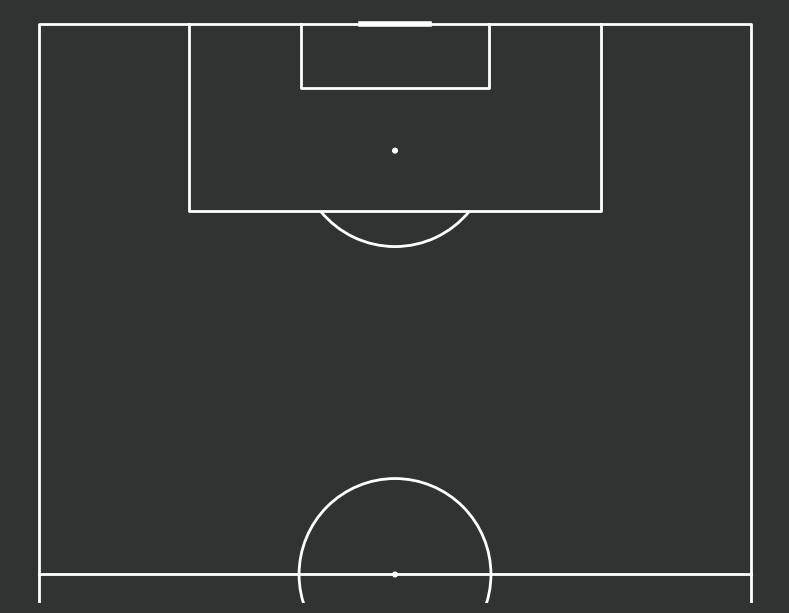

In [11]:
# Viz 2: Assisted Goals
fig2 = plot_assisted_goals(
    csv_path='./outputs/messi_assisted_goals.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/02_assisted_goals.png'
)
print("Viz 2: Assisted Goals - Guardado")

Viz 3: Assist Passes - Guardado


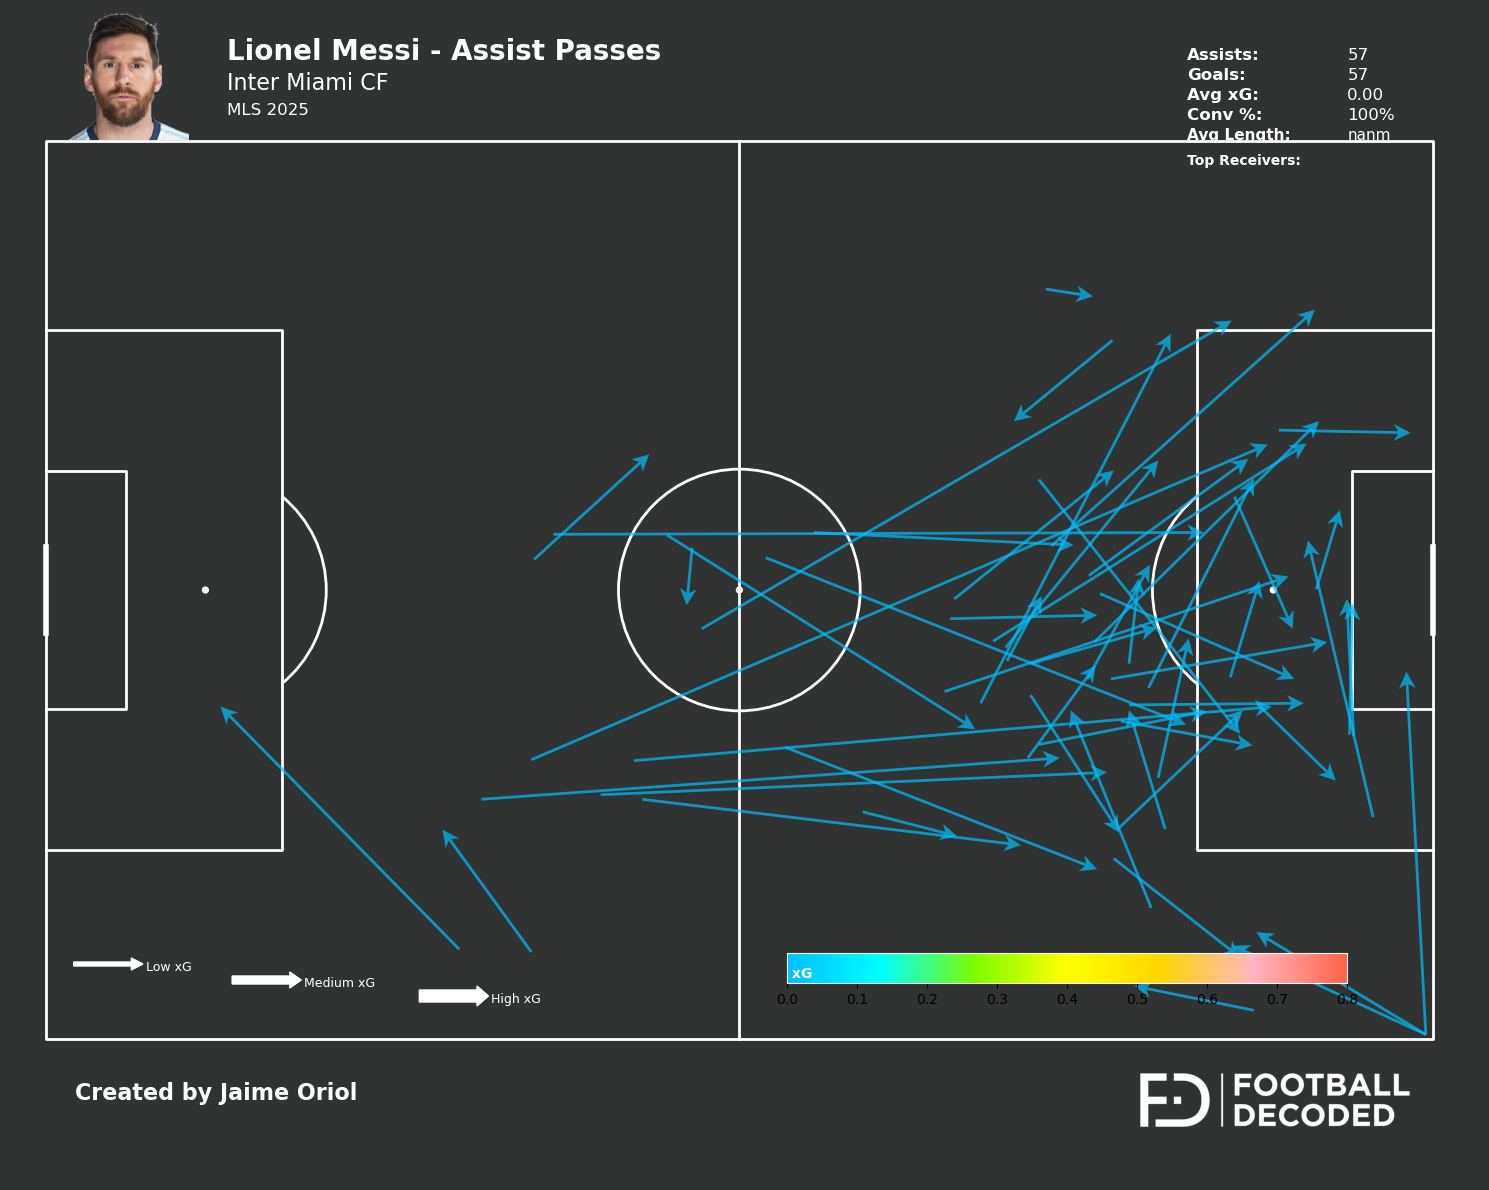

In [12]:
# Viz 3: Assist Passes
fig3 = plot_assist_passes(
    csv_path='./outputs/messi_assists.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/03_assist_passes.png'
)
print("Viz 3: Assist Passes - Guardado")

Viz 4: Dribbles Heatmap - Guardado


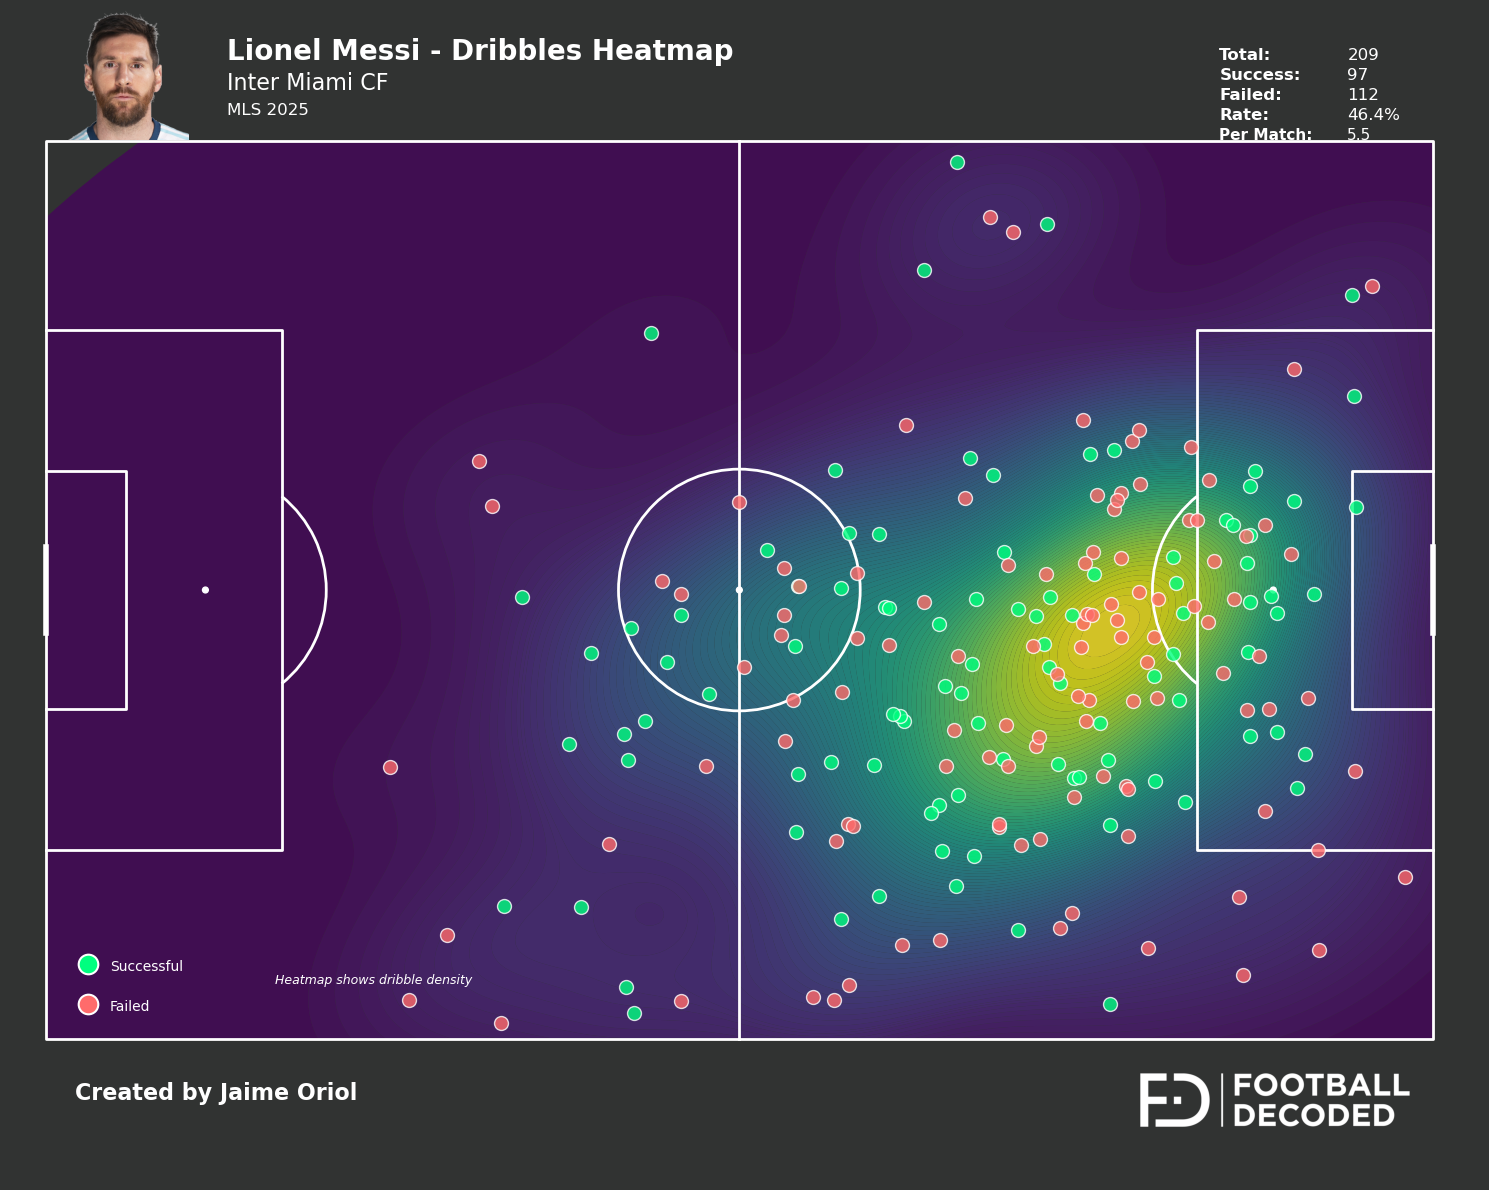

In [13]:
# Viz 4: Dribbles Heatmap
fig4 = plot_dribbles_heatmap(
    csv_path='./outputs/messi_dribbles.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    match_count=38,
    save_path='./outputs/plots/04_dribbles_heatmap.png'
)
print("Viz 4: Dribbles Heatmap - Guardado")